# Practical 2: Supervised learning framework and metrics

This week will introduce the supervised learning workflow using the use
case of predicting daily callouts in London.

## Learning Outcomes

-   You have familiarised yourself with the key steps in supervised
    machine learning workflow, including train-test split, cross
    validation, and hyperparameter tuning.
-   You are able to explain the differences between different workflows,
    including their pros and cons.

# Starting the Practical

The process for every week will be the same: download the notebook to
your `DSSS` folder (or wherever you keep your course materials), switch
over to `JupyterLab` (which will be running in Podman/Docker) and get to
work.

If you want to save the completed notebook to your Github repo, you can
`add`, `commit`, and `push` the notebook in Git after you download it.
When you’re done for the day, save your changes to the file (this is
very important!), then `add`, `commit`, and `push` your work to save the
completed notebook.

> **Note**
>
> Suggestions for a Better Learning Experience:
>
> -   **Set your operating system and software language to English**:
>     this will make it easier to follow tutorials, search for solutions
>     online, and understand error messages.
>
> -   **Save all files to a cloud storage service**: use platforms like
>     Google Drive, OneDrive, Dropbox, or Git to ensure your work is
>     backed up and can be restored easily when the laptop gets stolen
>     or broken.
>
> -   **Avoid whitespace in file names and column names in datasets**

# London Fire Brigade Dataset

The London Fire Brigade (LFB) provides an open dataset containing
information about multi-year fire incidents and fire engine moblisations
in London. The fire incident dataset includes various details such as
the location, time, and type of fire incidents, which can be useful for
various analyses, including supervised learning tasks. The original
dataset is available at
[here](https://data.london.gov.uk/dataset/london-fire-brigade-incident-records-em8xy/).

For convenience, we’ve processed and saved a subset of the LFB incident
dataset in 2023 as `LFB_2023_daily_data.csv` (containing aggregated
daily callouts in London) and `LFB_2023_data.csv` (containing individual
incident information). The Python notebook for processing the original
dataset is available
[here](https://raw.githubusercontent.com/huanfachen/DSSS_2025/refs/heads/main/data/processing_LFB_data.ipynb).

## Key considerations

It is worthwhile reading the
[metadata](https://data.london.gov.uk/download/em8xy/cb9d6550-e502-40a9-a5e4-1f055f31316f/Metadata.xlsx)
before formatting a problem. The following are some key points to note:

1.  The `IncidentGroup` column indicates the high-level incident type
    and consists of the following categories: `False Alarm`, `Fire`,
    `Special Service`. The ‘special service’ type refers to non-fire
    incidents, including assistance to other emergency services, such as
    helping with moving larger (i.e. bariatric) patients/people or
    rescuing people from lifts/elevators. The `False Alarm` type refers
    to fire callouts where no actual fire or emergency was present, and
    is further divided into three subtypes, including `AFA`,
    `False alarm - Good intent`, and `False alarm - Malicious` (see
    `StopCodeDescription` column). Obviously, if your research question
    is about fire incidents or fire risk, you should only focus on the
    `Fire` and `False Alarm` types in this column and remove
    `Special Service` type.
2.  The location precision of incidents at Dwellings (i.e. residential
    buildings) is limited to the postcode district level (e.g. N2) for
    data privacy reasons. Therefore, the columns of `Postcode_full`,
    `UPRN`, `Easting_m`, `Northing_m`, `Latitude`, and `Longitude` are
    redacted or removed for Dwellings. This means that if you want to
    conduct geospatial analysis at a fine spatial resolution
    (e.g. building or street level), you should exclude incidents at
    Dwellings. If you want to conduct geospatial analysis for all
    incidents (including Dwellings), you should use spatial
    granularities coarser than postcode district level (e.g. boroughs,
    the whole London).

## Stakeholders of fire service research

It is important to consider the potential stakeholders who might benefit
from the insights derived from (geospatial) research of fire services.
As far as I know, potential stakeholders include:

1.  Local fire services including London Fire Brigade. Each fire service
    department has their data analyst and GIS team. They would be
    interested in understanding the patterns and trends of fire
    incidents to improve resource allocation, response times, and
    overall effectiveness of fire services. So far, the UK fire services
    don’t have lots of collaborations with academic researchers. If they
    need GIS expertise, they always outsource to private companies, such
    as [Cadcorp](https://www.cadcorp.com/) and
    [ORH](https://www.orhltd.com/).

2.  National Fire Chiefs Council (NFCC, [link](https://nfcc.org.uk/)).
    NFCC is a non-charity body representing Fire & Rescue Services at a
    national level and, as the professional voice of the fire and rescue
    service and aim for maximum impact. They strive to harness knowledge
    and expertise from across the country, bringing it together for the
    benefit of all.

## Potential Use Cases

The LFB dataset can be used to formulate various supervised learning
tasks:

-   Regression
    -   Predicting daily LFB callouts in the whole London or each
        borough. Possible features include weather data, working day,
        public holiday, season, etc.
    -   Time series forecasting of daily LFB callouts in the whole
        London or each borough using historical data. Possible features
        include historical callout data, weather data, working day,
        public holiday, season, etc.
-   Classification
    -   Predicting whether a fire incident is a false alarm given the
        location available at the time of the callout, which includes
        time of day, day of week, postcode district, building type
        (dwelling or commercial).
-   etc.

# Predicting daily LFB callouts

We will demonstrate how to formulate a regression problem to predict
daily LFB callouts in London using weather and temporal features and how
to compute the metrics for this problem. As we haven’t covered the
workflow (e.g. train-test split, cross validation) of supervised
learning or the algorithsm, we will use a basic workflow and the random
forest algorithm.

In [1]:
# import data from https://raw.githubusercontent.com/huanfachen/DSSS_2025/refs/heads/main/data/LFB_2023_daily_data.csv
import pandas as pd
df_lfb_daily = pd.read_csv("https://raw.githubusercontent.com/huanfachen/DSSS_2025/refs/heads/main/data/LFB_2023_daily_data.csv")
print(df_lfb_daily.columns)

Index(['DateOfCall', 'IncidentCount', 'DATE', 'TX', 'Q_TX', 'TN', 'Q_TN', 'TG',
       'Q_TG', 'SS', 'Q_SS', 'SD', 'Q_SD', 'RR', 'Q_RR', 'QQ', 'Q_QQ', 'PP',
       'Q_PP', 'HU', 'Q_HU', 'CC', 'Q_CC', 'IsWeekend', 'weekday',
       'IsBankHoliday'],
      dtype='object')


The list of columns is explained as follows:

| Name | Example | Notes |
|--------------------|-----------------------------|-----------------------|
| DateOfCall | 2023-01-01 | The date when the fire incidents occurred |
| IncidentCount | 402 | Total number of fire incidents on that day (target variable for regression) |
| DATE | 2023-01-01 | Date in YYYYMMDD format (duplicate of DateOfCall) |
| TX | 93.0 | Daily maximum temperature in 0.1°C |
| TN | 100.0 | Daily minimum temperature in 0.1°C |
| TG | 112.0 | Daily mean temperature in 0.1°C |
| SS | 0.0 | Daily sunshine duration in 0.1 hours |
| SD | 0.0 | Daily snow depth in 1 cm |
| RR | 46.0 | Daily precipitation amount in 0.1 mm |
| QQ | 21.0 | Daily global radiation in W/m² |
| PP | 10080.0 | Daily sea level pressure in 0.1 hPa |
| HU | 81.0 | Daily relative humidity in % |
| CC | 7.0 | Daily cloud cover in oktas (scale 0-8, where 8 is completely overcast) |
| Q\_\* | 0, 1, or 9 | Each weather column includes a quality code. 0 for valid data, 1 for suspect data, 9 for missing data |
| IsWeekend | 1 | Binary indicator: 1 if weekend, 0 if weekday |
| weekday | Sunday | Name of the day of the week |
| IsBankHoliday | 0 | Binary indicator: 1 if bank holiday, 0 otherwise |

We will use all weather features and temporal features (IsWeekend,
weekday, IsBankHoliday) to predict the daily incident count.

In [2]:
# using Random Forest to predict IncidentCount using weather, weekday, weekend, and bank holiday info
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# prepare data for modeling
feature_cols = ['TX', 'TN', 'TG', 'SS', 'SD','RR','QQ', 'PP','HU','CC', 'IsWeekend', 'IsBankHoliday', 'weekday']
X = df_lfb_daily[feature_cols]
y = df_lfb_daily['IncidentCount']
# one-hot encode the 'weekday' column
X = pd.get_dummies(X, columns=['weekday'], drop_first=True)
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# train Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# evaluate model performance on training and testing sets
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = mse_train ** 0.5
rmse_test = mse_test ** 0.5

print(f'Train RMSE: {rmse_train:.3f}')
print(f'Test RMSE: {rmse_test:.3f}')

# compute R-squared on training and testing data. model.score() returns R-squared for regression models
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)

print(f'Train R-squared: {r2_train:.3f}')
print(f'Test R-squared: {r2_test:.3f}')

Train RMSE: 11.653
Test RMSE: 35.586
Train R-squared: 0.918
Test R-squared: 0.180


Another approach to computing R2 in sklearn is to call the `r2_score`
function, which is more explicit.

In [3]:
from sklearn.metrics import r2_score
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print(f'Train R-squared: {r2_train:.3f}')
print(f'Test R-squared: {r2_test:.3f}')

Train R-squared: 0.918
Test R-squared: 0.180


In [4]:
print(df_lfb_daily['IncidentCount'].mean())
print(y_test.mean())

346.467032967033
343.4931506849315


## Interpretation of metrics

On the testing data, the RMSE is around 35.6, which means that the
average prediction error is around 35.6 callouts per day. We can compare
this RMSE with the mean daily callouts (around 346.5) to understand the
relative size of the error, but this is not **very useful** as it does
not consider the variance in daily callouts.

The R-squared on the testing data is around 0.18, which means that
around 18% of the variance in daily callouts can be explained by the
weather and temporal features used in the model. In comparison, the
R-squared on the training data is around 0.92, which indicates that the
model fits the training data well but does not generalise well to unseen
data (i.e., overfitting).

This suggests that the model may need further tuning or that additional
features may be needed to improve its predictive performance.

# Predicting false alarm

We will now demonstrate how to formulate a classification problem that
predicts if a callout to LFB is a actual fire or false alarm. As above,
we will use a basic workflow and the random forest algorithm, and the
focus here is to practice with different metrics for classification
problems.

In [5]:
# import data from https://raw.githubusercontent.com/huanfachen/DSSS_2025/refs/heads/main/data/LFB_2023_data.csv
import pandas as pd
df_lfb = pd.read_csv("https://raw.githubusercontent.com/huanfachen/DSSS_2025/refs/heads/main/data/LFB_2023_data.csv")
# add DayOfWeek column
df_lfb['DayOfWeek'] = pd.to_datetime(df_lfb['DateOfCall']).dt.day_name()
print(df_lfb.columns)

Index(['IncidentNumber', 'DateOfCall', 'CalYear', 'TimeOfCall', 'HourOfCall', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory',
       'PropertyType', 'AddressQualifier', 'Postcode_full', 'Postcode_district', 'UPRN', 'USRN', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode',
       'IncGeo_WardName', 'IncGeo_WardNameNew', 'Easting_m', 'Northing_m', 'Easting_rounded', 'Northing_rounded', 'Latitude', 'Longitude', 'FRS', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime', 'FirstPumpArriving_DeployedFromStation', 'SecondPumpArriving_AttendanceTime', 'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount', 'PumpMinutesRounded', 'Notional Cost (£)', 'NumCalls', 'DayOfWeek'],
      dtype='object')


We will print the proportion of each incident group in the
`IncidentGroup` column.

In [6]:
print(df_lfb['IncidentGroup'].value_counts(normalize=True))

IncidentGroup
False Alarm        0.497899
Special Service    0.374637
Fire               0.127464
Name: proportion, dtype: float64


There are far more False Alarms (49.8%) than Fires (12.7%) in the
dataset, which indicates class imbalance.

We will remove the `Special Service` type in the `IncidentGroup` column
and formulate a binary classification problem to predict whether a
callout is a false alarm (`False Alarm`) or an actual fire (`Fire`)
using the following features available at the time of the callout:

-   Time of day (`HourOfCall`)
-   Day of week (`DayOfWeek`)
-   Building type (`PropertyCategory`).

As the `Fire` is a minority class, we will consider `Fire` as the
positive class (`1`) and `False Alarm` as the negative class (`0`).

In [7]:
# import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.metrics import classification_report
# remove 'Special Service' type
df_lfb = df_lfb[df_lfb['IncidentGroup'].isin(['False Alarm', 'Fire'])]

# proportion of both class
print("proportion of Fire and False Alarm:")
print(df_lfb['IncidentGroup'].value_counts(normalize=True))

# prepare data for modeling
feature_cols = ['HourOfCall', 
'DayOfWeek',
'PropertyCategory']
X = df_lfb[feature_cols]

# one-hot encode categorical features
X = pd.get_dummies(X, columns=[
  'DayOfWeek', 
  'PropertyCategory'], drop_first=True)
y = df_lfb['IncidentGroup'].map({'False Alarm': 0, 'Fire': 1})  # map to binary labels

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# evaluate model performance on testing set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')
# print classifcation report

print(classification_report(y_test, y_pred, target_names=['False Alarm', 'Fire']))

proportion of Fire and False Alarm:
IncidentGroup
False Alarm    0.796176
Fire           0.203824
Name: proportion, dtype: float64
Accuracy: 0.881
Precision: 0.778
Recall: 0.569
F1-score: 0.657
              precision    recall  f1-score   support

 False Alarm       0.90      0.96      0.93     12617
        Fire       0.78      0.57      0.66      3157

    accuracy                           0.88     15774
   macro avg       0.84      0.76      0.79     15774
weighted avg       0.87      0.88      0.87     15774



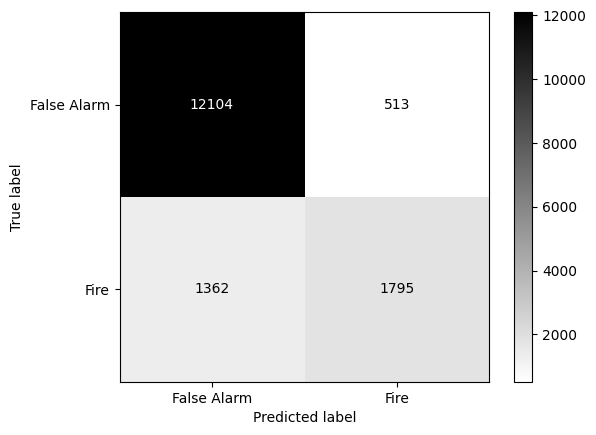

In [8]:
# print the confusion matrix using ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['False Alarm', 'Fire']).plot(cmap='gray_r')

## Interpretation of metrics

As the target variable is highly imbalanced (79.6% False Alarm VS. 20.4%
Fire), accuracy might not be a very useful metric here. A majority
strategy that predicts everything as False Alarm would achieve an
accuracy of around 0.796, which is similar to the accuracy of our RF
model (around 0.881).

Considering recall and precision, which one is more reasonable for this
task? In the fire service context, *predicting a Fire as a False Alarm*
(i.e., false negative) is more serious than *predicting a False Alarm as
a Fire* (i.e., false positive), as the former may lead to delayed
response to actual fires. Therefore, we would like to predict all Fires
correctly, in other words, maximising recall (or sensitivity).
Therefore, recall is a more suitable metric than precision for this
task.

To compare the performance and predictive power of our model against the
majority strategy, the followign code is useful:

In [9]:
import numpy as np
import pandas as pd
# majority strategy: predict everything as False Alarm (0)
y_pred_majority = np.zeros_like(y_test)
accuracy_majority = accuracy_score(y_test, y_pred_majority)
precision_majority = precision_score(y_test, y_pred_majority, zero_division=0)
recall_majority = recall_score(y_test, y_pred_majority)
f1_majority = f1_score(y_test, y_pred_majority)
# create a comparison table

comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Majority Strategy'],
    'Accuracy': [accuracy, accuracy_majority],
    'Precision': [precision, precision_majority],
    'Recall': [recall, recall_majority],
    'F1-score': [f1, f1_majority]
})

# limit the decimal places to 3
print(comparison_df.round(3))

               Model  Accuracy  Precision  Recall  F1-score
0      Random Forest     0.881      0.778   0.569     0.657
1  Majority Strategy     0.800      0.000   0.000     0.000


The precision and recall of the majority strategy are both zero, which
indicates that it has no predictive power for the minority class
(i.e. Fire). In comparison, our RF model has a precision of around 0.778
and a recall of around 0.569.

# Future directions

That’s mostly for this practical. In the following weeks, we will cover
more details about supervised learning:

1.  Analysis workflow (including train-test split, cross validation,
    hyperparameter tuning) in W3
2.  Tree-based methods in W4
3.  Model interpretation in W7
4.  Imbalanced data handling in W8

Meanwhile, for the above fire service research, we can include more
features (e.g. land use, socio-economic, historical fire incident
density, remote sensing) to improve the model performance.

## References and recommendations:

1.  There is not much (geospatial) machine learning research on London
    Fire Brigade datasets in academia. The [blog by GTH
    Consulting](https://www.gthconsulting.co.uk/blog-list) provides some
    interesting articles on fire service data analysis in the UK, which
    receive lots of comments on LinkedIn
    (e.g. [this](https://www.linkedin.com/posts/gth-consulting_fire-risk-assessment-activity-7049279279279279360-7v5A)).